# Numerical Calculation of Hessian Matrix

This is a simple example of a linear fit using the `L-BFGS-B` bounded minimizer.

The `L-BFGS-B` algorithm is very handy because it allows you to specify parameter bounds during minimization. However, the inverse Hessian matrix returned by  `scipy.optimize.minimize` when using this algorithm can be:
1. Tricky to use, because it's not always returned as a numpy array.
1. Relatively inaccurate for the purposes of estimating uncertainties.

Remember that we want to compute the uncertainty with respect to a parameter $x$ using

$$
\sigma_x = \left(-\frac{\partial^2\log{\mathcal{L}}}{\partial x^2}\right)^{-1/2}=\sqrt{-\left(H^{-1}\right)_{xx}}.
$$

This notebook demonstrates how to numerically compute the Hessian if we don't trust or use the values directly from the minimizer.

In [2]:
import numpy as np
from scipy.optimize import minimize

import numdifftools as ndt

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=18)
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', serif='palatino')

## Model Generation

Generate a linear data set with uncertainties distributed according to $\mathcal{N}(0.1,0.5)$. The default intercept $a$, slope $b$, and underestimate fraction $f$ are defined below.

In [3]:
np.random.seed(123)

# Choose the "true" parameters.
a_true = 4.294
b_true = -0.9594
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = a_true + b_true*x
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

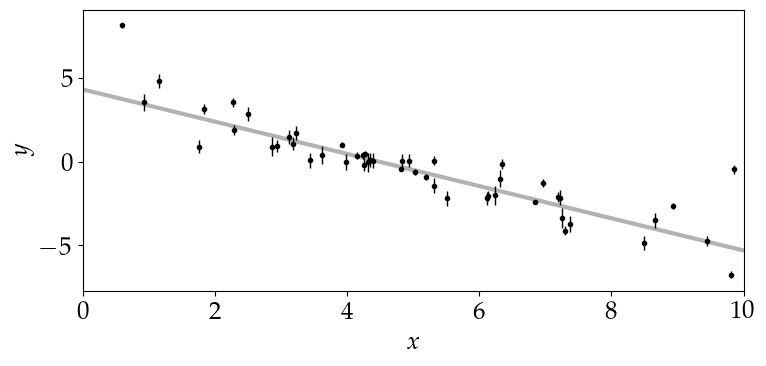

In [5]:
fig, ax = plt.subplots(1,1, figsize=(8,4), tight_layout=True)

ax.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0, lw=1)

x0 = np.linspace(0, 10, 500)
ax.plot(x0, a_true + b_true*x0, 'k', alpha=0.3, lw=3)
ax.set(xlim=(0,10), xlabel='$x$', ylabel='$y$');

# fig.savefig('linear-model.pdf')

## Maximum Likelihood

Fit with a Gaussian log-likelihood that includes the fractional underestimate in the variance of each point:

$$
\ln{\mathcal{L}} = \ln{p(y|a,b,f)} =
-\frac{1}{2}\sum_{i=1}^N \left[\left(\frac{y_i-a-bx_i}{s_i}\right)^2 + \ln{(2\pi s_i^2)}\right],
$$
where

$$
s_i^2 = \sigma_i^2 + f^2(a + bx_i)^2.
$$
Note that in the log-likelihood the model parameter will actually be $\ln{f}$.

In [4]:
# Log-likelihood
def loglike(theta):
    a, b, lnf = theta
    model = a + b*x
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# Define a negative LL for minimizers.
nloglike = lambda theta: -loglike(theta)

### Minimize the Negative Log Likelihood

Use the bounded minimizer `L-BFGS-B`.

In [5]:
p0 = [4., -1., -0.7]

bestfit = minimize(nloglike, p0, method='L-BFGS-B',
                   bounds=((0.,10.),
                           (-10.,0.),
                           (-10.,10.)))

bestfit

      fun: 12.182413948131622
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.64135372e-04, -8.55848725e-04,  8.34887715e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 88
      nit: 15
   status: 0
  success: True
        x: array([ 4.52831507, -1.0030088 , -0.79043918])

### Plot the Best Fit with the Data

Plot the best-fit line + residuals.

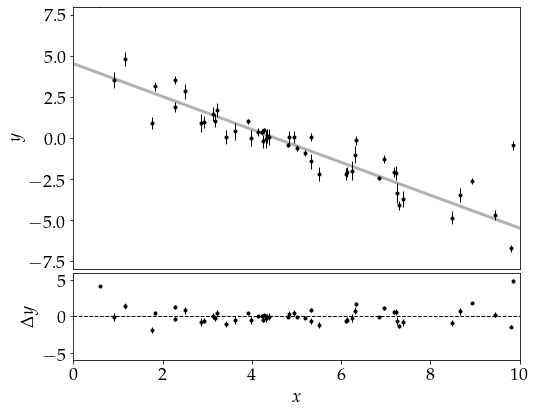

In [6]:
fig, axes = plt.subplots(2,1, figsize=(8,6.5),
                         gridspec_kw={'height_ratios':[3,1], 'hspace':0.02})

# Plot the data
ax = axes[0]
ax.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0, lw=1)

# Plot the best fit
x0 = np.linspace(0, 10, 500)
a, b, lnf = bestfit.x
ax.plot(x0, a + b*x0, 'k', alpha=0.3, lw=3)
ax.set(xlim=(0,10), xticks=[], ylim=(-8,8), ylabel='$y$')

# Plot the fit residuals
ax = axes[1]
ax.errorbar(x, y-(a + b*x), yerr=yerr, fmt='.k', capsize=0, lw=1)
ax.set(xlim=(0,10), xlabel='$x$', ylim=(-6,6), ylabel=r'$\Delta y$')
ax.axhline(ls='--', lw=1, color='k');

## Compute Parameter Uncertainties

The `L-BFGS-B` algorithm can return an operator object rather than the inverse of the Hessian matrix, so we can convert it to matrix form and take the square root of the diagonals.

In [7]:
uncertainty = np.sqrt(np.diag(bestfit.hess_inv.todense()))
labels = ['a', 'b', 'lnf']

for i in range(3):
    print('{:<4s} = {:9.4f} +- {:6.4f}'.format(labels[i], bestfit.x[i], uncertainty[i]))

a    =    4.5283 +- 1.4169
b    =   -1.0030 +- 0.3729
lnf  =   -0.7904 +- 2.1996


The uncertainties are relatively large, which is suspicious given the spread of the data around the best fit model.

#### Numerically Compute the Hessian

Check against a numerical evaluation of the Hessian around the maximum likelihood value. We'll need to invert the Hessian, and if we evaluate it for the likelihood rather than the negative log likelihood, we'll also need to negate the inverse before taking the square root.

In [8]:
loglike(bestfit.x)

-12.182413948131622

In [9]:
hessian = ndt.Hessian(loglike)
hess_ll = hessian(bestfit.x)
hess_inv = np.linalg.inv(hess_ll)

In [10]:
uncertainty = np.sqrt(np.diag(-hess_inv))

for i in range(3):
    print('{:<4s} = {:9.4f} +- {:6.4f}'.format(labels[i], bestfit.x[i], uncertainty[i]))

a    =    4.5283 +- 0.3562
b    =   -1.0030 +- 0.0780
lnf  =   -0.7904 +- 0.1550


Notice how the uncertainties are quite a bit smaller!

Based on our knowledge of this problem (see the other notebooks using MCMC and nested sampling on the same dataset) the numerically computed Hessian seems to give a pretty reasonable estimate of the uncertainties.